# Robust classification of digits by polynomials

In this notebook, we will demonstrate that the proposed framework is applicable to real-world scrnarios. We will train a Chebyshev polynomial to label a pictures as being one of the digits 0 to 9. We will use a subset of UCI digits dataset that is available in the scikit-learn python package. Each sample is a 8x8 grayscale picture. We will transform the samples to fit inside $x\in[-1,1]^{64}$.

We will use the Chebyshev polynomials $T_\alpha$ as features. However, it would be computationally intractable to to include all possible polynomial bases in the hypothesis. To see why, consider the count of all polynomial bases where each $x_i$ has a degree of at most one. This set has the same cardinality with a set that contains all possible subsets of $\{x_i\}_{i=1}^{64}$, i.e. the power set of $\{x_i\}_{i=1}^{64}$. Consequently, we have to decide which polynomial basis would be added to the hypothesis.

To do so, we enumerate all the possible walks up to $D$ steps on a 8x8 lattice, and then map each walk to a polynomial. A node in the lattice represents a pixel, and the structure of the lattice represents the structure of a 2D image. A walk with $D$ steps would be mapped to a degree $D$ polynomial. For example, the following walk
$$
x_{00} \rightarrow x_{01} \rightarrow x_{11} \rightarrow x_{10} \rightarrow x_{00}
$$
would be mapped to
$$
T_2(x_{00})T_1(x_{01})T_1(x_{11})T_1(x_{10}).
$$

In [1]:
import networkx as nx

def all_paths(G, max_depth, history=None, depth=1, paths=None, graph_search=False):
    if depth > max_depth:
        return []

    if paths is None:
        paths = set()

    if history is None:
        for v in G:
            hist = [v]
            paths.add(tuple(hist))
            all_paths(G, max_depth, hist, depth+1, paths)
    else:
        for v in G[history[-1]]:
            if graph_search and v in history:
                continue
            hist = history + [v]
            paths.add(tuple(sorted(hist)))
            all_paths(G, max_depth, hist, depth+1, paths)

    return list(sorted(paths))

def get_basis(G, deg):
    paths = all_paths(G, deg)

    basis = []
    for path in paths:
        j, d = [], []
        for v in set(path):
            j.append(v[0]*8+v[1])
            d.append(path.count(v))
        basis.append((j, d))
    return basis

G = nx.generators.lattice.grid_2d_graph(8, 8)

# We add self-loops to each node so that a node could be repeated in the walk even when the length
# of the walk is less than the lenght of the shortest loop in the graph
for v in G:
    G.add_edge(v, v)

Now that we have choosen our set of features, we can apply the proposed robust framework to train a robust classifier for the digits dataset. First, we will load and preprocess the dataset.

In [2]:
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split

digits = datasets.load_digits()

# flatten the images
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# Scale the pixels into [-1, 1] interval
X_train = X_train / 8 - 1
X_test = X_test / 8 - 1

We will need to compute the tunning matrix for the set of bases.

In [3]:
import numpy as np
from itertools import combinations_with_replacement, repeat

def Itv(bi, bj):
    """
    Helper function for computing the inner product between Chebyshev polynomials of the first kind
    """
    return np.where(bi == bj, np.where(bi == 0, 1, 1/2), 0)

def Iuv(bi, bj):
    """
    Helper function for computing the inner product between Chebyshev polynomials of the second kind
    """
    return np.where((bi % 2) == (bj % 2), np.where(bi % 2 == 0, 1 + 2 * np.floor(np.minimum(bi, bj) / 2), 2 * np.ceil(np.minimum(bi, bj) / 2)), 0)

def Ib(bi, bj):
    """
    Helper function for computing the tuning matrix
    """
    res = 0
    N = len(bi)
    temp = Itv(bi, bj) ** (1 - np.eye(bi.size))
    res = np.sum(bi * bj * Iuv(bi - 1, bj - 1) * np.prod(temp, axis=-1))
    return res

def tunning_mat(basis):
    M = len(basis)
    MM = M*(M-1) / 2 + M
    Sigma = np.eye(M)

    counter = 0
    for i, j in combinations_with_replacement(range(M), r=2):
        if counter%100 == 0: print('\rcomputing the tuning matrix %f' % (counter / MM), end='')
        counter += 1
        bi = np.zeros(64)
        bi[basis[i][0]] = basis[i][1]
        bj = np.zeros(64)
        bj[basis[j][0]] = basis[j][1]
        inner = Ib(bi, bj)
        Sigma[(i, j), (j, i)] = inner
    print()
    return Sigma

Finally, we implement a one-step $\ell^2$ normalized gradient based attack to see how robust the output of the learning rules are.

In [4]:
from scipy.misc import derivative

def attack_grad(clf, x, y, C):
    def obj(r, i):
        _x = np.copy(x)
        _x[0, i] = r

        log_proba = clf(_x)
        return log_proba[0, y]
    
    x = x[None, :]
    grad = np.array([derivative(lambda r: obj(r, i), x[0, i]) for i in range(x.shape[1])])
    adv_dir = grad / np.linalg.norm(grad, ord=2)

    return np.clip(x - C * adv_dir[None, :], -1, 1)

Next, we will conduct an experiment to show that the proposed framework would indeed result in a hypothesis that is more robust against adversarial attacks. To do so, we will train orthonormal and harmonic Chebyshev polynomials of increasing degree, and compare their performance against a blackbox attack. We will use a MLP classifier as the surrogate.

In [5]:
from sklearn.neural_network import MLPClassifier

def f1(clf, X, y):
    yhat = clf.predict(X)
    return metrics.f1_score(yhat, y, pos_label=None, average='weighted')


cls_mlp = MLPClassifier(hidden_layer_sizes=(40, 30, 20), activation='relu', solver='adam', random_state=2)
cls_mlp.fit(X_train, y_train)

nat_mlp_score = f1(cls_mlp, X_test, y_test)

print('Accuracy of MLP classifier on natural samples: %1.2f' % nat_mlp_score)

adv_mlp = []
counter = 0
for x, y in zip(X_test, y_test):
    if counter % 100 == 0:
        print('\rattacking the test set %f' % (counter / X_test.shape[0]), end='')
    counter += 1
    adv_mlp.append(attack_grad(cls_mlp.predict_log_proba, x, y, 1))
print('\rattacking the test set 1.0')
adv_mlp = np.vstack(adv_mlp)

adv_mlp_score = f1(cls_mlp, adv_mlp, y_test)
print('Accuracy of MLP classifier on adversarial samples: %1.2f' % adv_mlp_score)

Accuracy of MLP classifier on natural samples: 0.94
attacking the test set 0.889878
Accuracy of MLP classifier on adversarial samples: 0.61


In [6]:
from numpy.polynomial import chebyshev as ch
from itertools import product
from scipy.linalg import sqrtm

def vander(X, basis, deg, verbose=True):
    N = X.shape[0]
    M = len(basis)
    V = np.ones((N, M))
    for n, m in product(range(N), range(M)):
        if verbose and n%10 == 0 and m%M == 0: print('\rcomputing the Vandermonde matrix %1.2f' % (n/N), end='')
        v = ch.chebvander(X[n], deg)
        V[n, m] = np.prod(v[basis[m]])
    print()
    return V

degrees = [1, 2, 3, 4]

nat_orth_score = []
nat_sync_score = []

adv_orth_score = []
adv_sync_score = []

for deg in degrees:
    basis = get_basis(G, deg)

    # Orth
    V_train_orth = vander(X_train, basis, deg)
    V_test_orth = vander(X_test, basis, deg)

    clf_orth = svm.LinearSVC()
    clf_orth.fit(V_train_orth, y_train)

    nat_orth_score.append(f1(clf_orth, V_test_orth, y_test))
    V_orth_adv = vander(adv_mlp, basis, deg)
    adv_orth_score.append(f1(clf_orth, V_orth_adv, y_test))
    # Orth

    # Harm
    Sigma = tunning_mat(basis)
    Lambda = np.real(sqrtm(np.linalg.inv(Sigma)))

    V_train_harm = V_train_orth @ Lambda
    V_test_harm = V_test_orth @ Lambda

    clf_harm = svm.LinearSVC()
    clf_harm.fit(V_train_harm, y_train)

    nat_sync_score.append(f1(clf_harm, V_test_harm, y_test))
    V_harm_adv = V_orth_adv @ Lambda
    adv_sync_score.append(f1(clf_harm, V_harm_adv, y_test))
    # Harm

computing the Vandermonde matrix 0.99
computing the Vandermonde matrix 0.99


C:\Users\Ramin\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


computing the Vandermonde matrix 0.99
computing the tuning matrix 0.961538


C:\Users\Ramin\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


computing the Vandermonde matrix 0.99
computing the Vandermonde matrix 0.99


C:\Users\Ramin\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


computing the Vandermonde matrix 0.99
computing the tuning matrix 0.999308


C:\Users\Ramin\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


computing the Vandermonde matrix 0.99
computing the Vandermonde matrix 0.99
computing the Vandermonde matrix 0.99
computing the tuning matrix 0.999970
computing the Vandermonde matrix 0.99
computing the Vandermonde matrix 0.99
computing the Vandermonde matrix 0.99
computing the tuning matrix 0.999977


In the end, we will plot the accuracy of each classifer on the natural and adversarial examples as a function of the maximum degree of the included polynomials.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


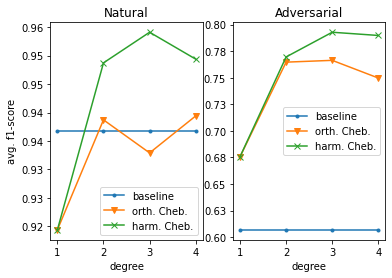

In [9]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(1, 2)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[0].set_title('Natural')
ax[0].plot(degrees, [nat_mlp_score] * len(degrees), label='baseline', marker='.')
ax[0].plot(degrees, nat_orth_score, label='orth. Cheb.', marker='v')
ax[0].plot(degrees, nat_sync_score, label='harm. Cheb.', marker='x')
ax[0].set_ylabel(r'avg. f1-score')
ax[0].set_xlabel(r'degree')
ax[0].legend()

ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[1].set_title('Adversarial')
ax[1].plot(degrees, [adv_mlp_score] * len(degrees), label='baseline', marker='.')
ax[1].plot(degrees, adv_orth_score, label='orth. Cheb.', marker='v')
ax[1].plot(degrees, adv_sync_score, label='harm. Cheb.', marker='x')
ax[1].set_xlabel(r'degree')
ax[1].legend()

fig.savefig('digits.eps', bbox_inches='tight', dpi=100)

The result suggests that as we include more polynomial bases, the harmonic hypothesis gets more robust. On the other hand, the orthonormal Chebyshev does not show the same pattern, and it seems that including higher degree polynomials would worsen its performance on adversarial examples. Moreover, we can see that the adversarial examples of the MLP classifier transfers to the polynomial hypothesis. This observation is inline with the prediction of our framework in which ANNs and polynomials are different representations of the same normal hypothesis class.